In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 
import matplotlib.colors as mcolors

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")


from src.functions.embryo_df_performance_metrics import *

from src.functions.spline_morph_spline_metrics import *

work_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315"
plot_dir = os.path.join(work_dir,"plots")
data_dir = os.path.join(work_dir,"data")


model_index = 74

cep290_file_path = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/data/embryo_stats_df.csv"

df_orig = pd.read_csv(cep290_file_path)

z_mu_columns = [col for col in df_orig.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]



cep290_genotypes = ['cep290_het_cep290', 
                         'wt_cep290', 'cep290_homo_cep290']

phenotypes_of_interest = ['cep290_het_cep290_temp30', 
                         'wt_cep290_temp30', 'cep290_homo_cep290_temp30']
                        

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [22]:

phenotypes_of_interest = ['cep290_het_cep290_temp30', 
                         'wt_cep290_temp30', 'cep290_homo_cep290_temp30']
                        

In [4]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import os
import random

def plot_pca_with_splines(df_points, df_splines, 
                         point_opacity=0.7, 
                         save_dir=None, 
                         downsample_dict=None, 
                         color_dict=None,
                         title="PCA Plot with Splines",
                         min_snip_count=20):
    """
    Plot PCA points and their splines with customizable options.
    
    Parameters:
    -----------
    df_points : pandas.DataFrame
        DataFrame containing the original points with columns 'PCA_1', 'PCA_2', 'PCA_3', 'phenotype',
        'embryo_id', and 'snip_id'
    df_splines : pandas.DataFrame
        DataFrame containing the spline data with columns 'PCA_1', 'PCA_2', 'PCA_3', and 'phenotype'
    point_opacity : float, optional (default=0.7)
        Opacity value for the points (0.0 to 1.0)
    save_dir : str, optional (default=None)
        Directory to save the plot. If None, the plot will not be saved.
    downsample_dict : dict, optional (default=None)
        Dictionary with phenotypes as keys and fraction of points to keep as values.
        Example: {'wt_temp22': 0.5} will randomly keep 50% of 'wt_temp22' points.
    color_dict : dict, optional (default=None)
        Dictionary with phenotypes as keys and colors as values.
        If None, colors will be automatically assigned.
    title : str, optional (default="PCA Plot with Splines")
        Title of the plot
    min_snip_count : int, optional (default=20)
        Minimum number of snips required for an embryo to be included in the plot.
        Embryos with fewer snips will be filtered out.
    
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The generated Plotly figure
    """
    # Filter embryos based on snip count
    embryo_counts = df_points.groupby('embryo_id')['snip_id'].count()
    valid_embryos = embryo_counts[embryo_counts >= min_snip_count].index.tolist()
    
    # Filter out embryos with too few snips
    removed_embryos = set(df_points['embryo_id'].unique()) - set(valid_embryos)
    if removed_embryos:
        print(f"Removed {len(removed_embryos)} embryos with fewer than {min_snip_count} snips.")
    
    # Filter dataframe to include only valid embryos
    filtered_df = df_points[df_points['embryo_id'].isin(valid_embryos)].copy()
    
    # Helper function to convert hex/named color to rgba with opacity
    def color_with_opacity(color_str, opacity):
        """Convert a color to an rgba string with the given opacity"""
        if color_str.startswith('#'):  # Hex color
            hex_color = color_str.lstrip('#')
            if len(hex_color) == 6:
                r, g, b = [int(hex_color[i:i+2], 16) for i in (0, 2, 4)]
                return f'rgba({r}, {g}, {b}, {opacity})'
            else:
                # Fall back to a basic case if hex format is unexpected
                return f'rgba(100, 100, 100, {opacity})'
        elif color_str.startswith('rgb'):  # RGB or RGBA color
            if color_str.startswith('rgba'):
                # Already has opacity, just modify the opacity part
                return color_str.rsplit(',', 1)[0] + f', {opacity})'
            else:  # RGB format, convert to RGBA
                return color_str.replace('rgb', 'rgba').rstrip(')') + f', {opacity})'
        else:  # Named color, use a default opacity approach
            # For simplicity, we'll use semi-transparent blue for any named colors
            # This is a simplification - for production you might want a more robust solution
            standard_colors = {
                'blue': 'rgba(0, 0, 255, {0})',
                'green': 'rgba(0, 128, 0, {0})',
                'red': 'rgba(255, 0, 0, {0})',
                'cyan': 'rgba(0, 255, 255, {0})',
                'magenta': 'rgba(255, 0, 255, {0})',
                'yellow': 'rgba(255, 255, 0, {0})',
                'purple': 'rgba(128, 0, 128, {0})',
                'orange': 'rgba(255, 165, 0, {0})',
                'brown': 'rgba(165, 42, 42, {0})',
                'pink': 'rgba(255, 192, 203, {0})',
                'gray': 'rgba(128, 128, 128, {0})',
                'darkgreen': 'rgba(0, 100, 0, {0})'
            }
            
            if color_str.lower() in standard_colors:
                return standard_colors[color_str.lower()].format(opacity)
            else:
                # Default for any unrecognized color name
                return f'rgba(100, 100, 100, {opacity})'
    
    # Get unique phenotypes
    phenotypes = filtered_df['phenotype'].unique()
    
    # Create color dictionary if not provided
    if color_dict is None:
        # Default color palette - can be extended with more colors if needed
        default_colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
            # Add more colors here if you want more distinct colors
        ]
        # Using modulo ensures we cycle through colors if we have more phenotypes than colors
        color_dict = {phenotype: default_colors[i % len(default_colors)] for i, phenotype in enumerate(phenotypes)}
        
        # Check if we have more phenotypes than colors (will cause color reuse)
        if len(phenotypes) > len(default_colors):
            print(f"Warning: More phenotypes ({len(phenotypes)}) than colors ({len(default_colors)}). Some colors will be reused.")
    
    # Create figure
    fig = go.Figure()
    
    # Process each phenotype
    for phenotype in phenotypes:
        # Filter points for this phenotype
        points = filtered_df[filtered_df['phenotype'] == phenotype].copy()
        
        # Apply downsampling if specified
        if downsample_dict is not None and phenotype in downsample_dict:
            fraction = downsample_dict[phenotype]
            if 0 < fraction < 1:
                # Randomly select a fraction of the points
                points = points.sample(frac=fraction, random_state=42)
        
        # Get color for this phenotype
        color = color_dict.get(phenotype, '#1f77b4')  # Default to blue if not in color_dict
        
        # Add points to plot with hover data
        fig.add_trace(
            go.Scatter3d(
                x=points['PCA_1'],
                y=points['PCA_2'],
                z=points['PCA_3'],
                mode='markers',
                marker=dict(
                    size=4,
                    color=color,
                    opacity=point_opacity
                ),
                name=f"{phenotype} (points)",
                showlegend=True,
                hovertemplate='<b>%{text}</b><br>PCA_1: %{x:.3f}<br>PCA_2: %{y:.3f}<br>PCA_3: %{z:.3f}<extra></extra>',
                text=[f"Embryo: {row['embryo_id']}<br>Snip: {row['snip_id']}<br>Phenotype: {row['phenotype']}" 
                      for _, row in points.iterrows()]
            )
        )
        
        # Add spline for this phenotype
        if df_splines is not None:
            spline = df_splines[df_splines['phenotype'] == phenotype]
            if not spline.empty:
                fig.add_trace(
                    go.Scatter3d(
                        x=spline['PCA_1'],
                        y=spline['PCA_2'],
                        z=spline['PCA_3'],
                        mode='lines',
                        line=dict(
                            color=color,
                            width=6
                        ),
                        name=f"{phenotype} (spline)",
                        showlegend=True
                    )
                )
    
    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis_title='PCA 1',
            yaxis_title='PCA 2',
            zaxis_title='PCA 3'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1
        )
    )
    
    # Save figure if save_dir is provided
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        fig.write_html(os.path.join(save_dir, f"{title.replace(' ', '_')}.html"))
        fig.write_image(os.path.join(save_dir, f"{title.replace(' ', '_')}.png"))
    
    return fig


def plot_embryo_trajectories(df_points, 
                            point_opacity=0.3,
                            line_opacity=0.7,
                            save_dir=None,
                            downsample_dict=None,
                            color_dict=None,
                            df_splines=None,
                            title="Embryo Trajectories",
                            min_snip_count=20):
    """
    Plot trajectories of individual embryos showing developmental paths.
    
    Parameters:
    -----------
    df_points : pandas.DataFrame
        DataFrame containing points with columns 'PCA_1', 'PCA_2', 'PCA_3', 'phenotype',
        'embryo_id', and 'snip_id'
    point_opacity : float, optional (default=0.3)
        Opacity value for the points (0.0 to 1.0), default is more translucent for trajectories
    save_dir : str, optional (default=None)
        Directory to save the plot. If None, the plot will not be saved.
    downsample_dict : dict, optional (default=None)
        Dictionary with phenotypes as keys and fraction of embryo_ids to keep as values.
        Example: {'wt_temp22': 0.1, 'cep290_homo_cep290_temp30': 0.5} will randomly keep 
        10% of 'wt_temp22' embryos and 50% of 'cep290_homo_cep290_temp30' embryos.
    color_dict : dict, optional (default=None)
        Dictionary with phenotypes as keys and colors as values.
        If None, colors will be automatically assigned.
    df_splines : pandas.DataFrame, optional (default=None)
        DataFrame containing spline data. Optional for trajectory plots.
    title : str, optional (default="Embryo Trajectories")
        Title of the plot
    min_snip_count : int, optional (default=20)
        Minimum number of snips required for an embryo to be included in the plot.
        Embryos with fewer snips will be filtered out.
    
    Returns:
    --------
    fig : plotly.graph_objects.Figure
        The generated Plotly figure
    """
    # Filter embryos based on snip count
    embryo_counts = df_points.groupby('embryo_id')['snip_id'].count()
    valid_embryos = embryo_counts[embryo_counts >= min_snip_count].index.tolist()
    
    # Filter out embryos with too few snips
    removed_embryos = set(df_points['embryo_id'].unique()) - set(valid_embryos)
    if removed_embryos:
        print(f"Removed {len(removed_embryos)} embryos with fewer than {min_snip_count} snips.")
    
    # Filter dataframe to include only valid embryos
    filtered_df = df_points[df_points['embryo_id'].isin(valid_embryos)].copy()
    
    # Downsample embryos if specified, using phenotype-specific rates
    if downsample_dict is not None:
        all_selected_embryos = []
        
        # Process each phenotype separately
        for phenotype, phenotype_data in filtered_df.groupby('phenotype'):
            unique_embryos = phenotype_data['embryo_id'].unique()
            
            # Apply downsampling if specified for this phenotype
            if phenotype in downsample_dict and 0 < downsample_dict[phenotype] < 1:
                sample_size = max(1, int(len(unique_embryos) * downsample_dict[phenotype]))
                selected_embryos = np.random.choice(unique_embryos, size=sample_size, replace=False)
                print(f"Downsampled {phenotype}: kept {len(selected_embryos)}/{len(unique_embryos)} embryos ({downsample_dict[phenotype]*100:.1f}%)")
                all_selected_embryos.extend(selected_embryos)
            else:
                # Keep all embryos for phenotypes not specified in downsample_dict
                all_selected_embryos.extend(unique_embryos)
        
        # Filter the dataframe to keep only selected embryos
        filtered_df = filtered_df[filtered_df['embryo_id'].isin(all_selected_embryos)]
    
    # Get unique phenotypes
    phenotypes = filtered_df['phenotype'].unique()
    
    # Create color dictionary if not provided
    if color_dict is None:
        # Default color palette - can be extended with more colors if needed
        default_colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
            '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
        ]
        # Using modulo ensures we cycle through colors if we have more phenotypes than colors
        color_dict = {phenotype: default_colors[i % len(default_colors)] for i, phenotype in enumerate(phenotypes)}
        
        # Check if we have more phenotypes than colors (will cause color reuse)
        if len(phenotypes) > len(default_colors):
            print(f"Warning: More phenotypes ({len(phenotypes)}) than colors ({len(default_colors)}). Some colors will be reused.")
    
    # Create figure
    fig = go.Figure()
    
    # Process each phenotype separately for legend grouping
    for phenotype in phenotypes:
        # Track first embryo for each phenotype (for legend purposes)
        phenotype_embryos = filtered_df[filtered_df['phenotype'] == phenotype]['embryo_id'].unique()
        
        for embryo_id in phenotype_embryos:
            # Get data for this embryo
            embryo_data = filtered_df[(filtered_df['embryo_id'] == embryo_id) & 
                                      (filtered_df['phenotype'] == phenotype)].copy()
            
            # Skip if somehow empty
            if embryo_data.empty:
                continue
                
            # Sort by snip_id to ensure correct trajectory path
            embryo_data = embryo_data.sort_values('snip_id')
            
            # Get color for this phenotype
            color = color_dict.get(phenotype, '#1f77b4')  # Default to blue if not in color_dict
            
            # Add points with hover data
            fig.add_trace(
                go.Scatter3d(
                    x=embryo_data['PCA_1'],
                    y=embryo_data['PCA_2'],
                    z=embryo_data['PCA_3'],
                    mode='markers',
                    marker=dict(
                        size=3,  # Smaller points for trajectories
                        color=color,
                        opacity=point_opacity  # More translucent for trajectories
                    ),
                    name=f"{phenotype} - Embryo {embryo_id}",
                    legendgroup=phenotype,
                    showlegend=False,  # Hide individual embryo points in legend
                    hovertemplate='<b>%{text}</b><br>PCA_1: %{x:.3f}<br>PCA_2: %{y:.3f}<br>PCA_3: %{z:.3f}<extra></extra>',
                    text=[f"Embryo: {row['embryo_id']}<br>Snip: {row['snip_id']}<br>Phenotype: {row['phenotype']}" 
                          for _, row in embryo_data.iterrows()]
                )
            )
            
            # Add trajectory lines with opacity
            is_first_embryo_of_phenotype = (embryo_id == phenotype_embryos[0])
            
            fig.add_trace(
                go.Scatter3d(
                    x=embryo_data['PCA_1'],
                    y=embryo_data['PCA_2'],
                    z=embryo_data['PCA_3'],
                    mode='lines',
                    line=dict(
                        color=color_with_opacity(color, line_opacity),
                        width=2
                    ),
                    name=f"{phenotype} trajectory",
                    legendgroup=phenotype,
                    showlegend=is_first_embryo_of_phenotype,  # Show only one legend entry per phenotype
                    hoverinfo='none'
                )
            )
    
    # Add splines if provided (optional)
    if df_splines is not None:
        for phenotype in phenotypes:
            # Filter spline for this phenotype
            spline = df_splines[df_splines['phenotype'] == phenotype]
            if not spline.empty:
                color = color_dict.get(phenotype, '#1f77b4')
                fig.add_trace(
                    go.Scatter3d(
                        x=spline['PCA_1'],
                        y=spline['PCA_2'],
                        z=spline['PCA_3'],
                        mode='lines',
                        line=dict(
                            color=color,
                            width=6
                        ),
                        name=f"{phenotype} (spline)",
                        showlegend=True
                    )
                )
    
    # Update layout
    fig.update_layout(
        scene=dict(
            xaxis_title='PCA 1',
            yaxis_title='PCA 2',
            zaxis_title='PCA 3'
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40),
        legend=dict(
            x=0.01,
            y=0.99,
            bordercolor="Black",
            borderwidth=1
        )
    )
    
    # Save figure if save_dir is provided
    if save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        fig.write_html(os.path.join(save_dir, f"{title.replace(' ', '_')}.html"))
        fig.write_image(os.path.join(save_dir, f"{title.replace(' ', '_')}.png"))
    
    return fig

In [19]:

cep290_genotypes = ['cep290_het_cep290', 
                         'wt_cep290', 'cep290_homo_cep290']


df_cep290 = df_orig[df_orig["short_pert_name"].isin(cep290_genotypes)]
df_cep290["phenotype"] = df_cep290["short_pert_name"]


df_wt = df_orig[df_orig["phenotype"]=="wt"]
df_wt = df_wt[~df_wt["short_pert_name"].isin(cep290_genotypes)]

# Combine wild-type and cep290 datasets
df = pd.concat([df_wt, df_cep290], ignore_index=True)

# Filter by temperature
df = df[df["temperature"].isin([30.0, 29.0, 22.0])]

# Append temperature to phenotype as a suffix
df["phenotype"] = df["phenotype"] + "_temp" + df["temperature"].astype(int).astype(str)

flagged_embryo_ids = ["20250305_B02_e00","20250305_G09_e00","20250305_H12_e00"]


df = df[~df["embryo_id"].isin(flagged_embryo_ids)]

df = apply_pca_on_pert_comparisons(df  ,z_mu_biological_columns )


/tmp/12456646.1.trapnell-login.q/ipykernel_2348883/2783333010.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cep290["phenotype"] = df_cep290["short_pert_name"]


No perturbations specified. Using all available phenotypes: ['wt_temp22', 'wt_temp30', 'wt_temp29', 'cep290_het_cep290_temp30', 'wt_cep290_temp30', 'cep290_homo_cep290_temp30']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 87.92%

Principal Component Explained Variance Ratio
              PCA_1                   45.00%
              PCA_2                   32.11%
              PCA_3                   10.81%
----------------------------



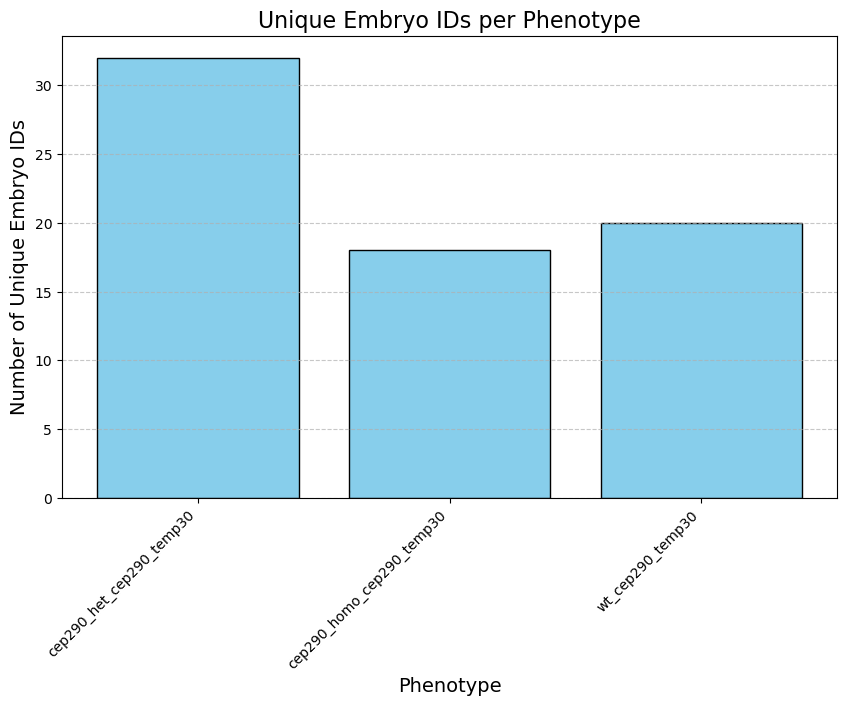

In [24]:
import matplotlib.pyplot as plt

                        
# Count unique embryo_id per phenotype
unique_embryo_counts = df[df["phenotype"].isin(phenotypes_of_interest)].groupby("phenotype")["embryo_id"].nunique().reset_index()
unique_embryo_counts.columns = ["phenotype", "num_unique_embryo_ids"]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(unique_embryo_counts["phenotype"], unique_embryo_counts["num_unique_embryo_ids"], color="skyblue", edgecolor="black")

# Labels and title
plt.xlabel("Phenotype", fontsize=14)
plt.ylabel("Number of Unique Embryo IDs", fontsize=14)
plt.title("Unique Embryo IDs per Phenotype", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if they are long
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [26]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df,
    # comparisons=pert_comparisons,
    save_dir=data_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
)

No comparisons specified. Using all available phenotypes: ['wt_temp22', 'wt_temp30', 'wt_temp29', 'cep290_het_cep290_temp30', 'wt_cep290_temp30', 'cep290_homo_cep290_temp30']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                                              | 0/6 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [1.21832422 1.65657832 2.49631853]


Creating splines for each phenotype:  17%|██████████████▎                                                                       | 1/6 [00:15<01:18, 15.80s/it]

Starting point not in dataset. Using closest point: [1.23264897 1.92836943 1.75392023]


Creating splines for each phenotype:  33%|████████████████████████████▋                                                         | 2/6 [00:27<00:52, 13.11s/it]

Starting point not in dataset. Using closest point: [1.17765168 1.74236527 2.29980791]


Creating splines for each phenotype:  50%|███████████████████████████████████████████                                           | 3/6 [00:40<00:39, 13.16s/it]

Starting point not in dataset. Using closest point: [-0.90901255  1.52974231 -0.51723496]


Creating splines for each phenotype:  67%|█████████████████████████████████████████████████████████▎                            | 4/6 [00:43<00:18,  9.34s/it]

Starting point not in dataset. Using closest point: [-1.20580484  1.52995697 -0.78427363]


Creating splines for each phenotype:  83%|███████████████████████████████████████████████████████████████████████▋              | 5/6 [00:46<00:06,  6.97s/it]

Starting point not in dataset. Using closest point: [-1.26612493  1.44056809 -0.54888655]


Creating splines for each phenotype: 100%|██████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:48<00:00,  8.12s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/data/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes:  67%|██████████████████████████████████████████████████████████████████▋                                 | 4/6 [02:20<01:00, 30.27s/it]/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
Processing phenotypes: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:38<00:00, 26.40s/it]


In [29]:

# Custom colors for specific phenotypes
color_dict = {
    'wt_temp30': 'blue',
    'cep290_het_cep290_temp30': 'purple',
    'wt_cep290_temp30': 'lightsteelblue',
    'cep290_homo_cep290_temp30': 'green'
}

# Downsample to reduce point density (especially helpful for large datasets)
downsample_dict = {
    'wt_temp30': 0.15   # Keep 5% of wt_temp30 points
}

# Define phenotypes of interest (must match those in color_dict)
phenotypes_of_interest = ['wt_temp30', 'cep290_het_cep290_temp30', 
                         'wt_cep290_temp30', 'cep290_homo_cep290_temp30']

# Filter dataframes to only include phenotypes of interest
filtered_points = df_augmented[df_augmented['phenotype'].isin(phenotypes_of_interest)]
filtered_splines = pert_splines[pert_splines['phenotype'].isin(phenotypes_of_interest)]

# Create and save the plot
fig = plot_pca_with_splines(
    df_points=filtered_points,
    df_splines=filtered_splines,
    point_opacity=0.5,  # Make points slightly transparent
    downsample_dict=downsample_dict,
    color_dict=color_dict,
    save_dir=plot_dir,
    title="CEP290 Phenotypes Comparison"
)

# Display the figure (optional if running in notebook)

# Create and save the phenotype-based PCA plot
fig_pca = plot_pca_with_splines(
    df_points=filtered_points,
    df_splines=filtered_splines,
    point_opacity=0.3,
    downsample_dict=downsample_dict,
    color_dict=color_dict,
    save_dir=plot_dir,
    title="CEP290 Phenotypes Comparison",
    min_snip_count=20  # Filter out embryos with fewer than 20 snips
)




Removed 85 embryos with fewer than 20 snips.


Removed 85 embryos with fewer than 20 snips.


In [33]:
import matplotlib.colors as mcolors

In [37]:

def split_train_test_stratified(df, pert_pair, pert_column='phenotype', embryo_id_column='embryo_id', test_size=0.2, random_state=42):
    """
    Splits a dataframe into training and test sets based on unique 'embryo_id',
    ensuring each perturbation in the pair has a proper train/test split.

    Parameters:
    df (pd.DataFrame): The dataframe containing the embryo data
    pert_pair (list): List of two perturbations to compare
    pert_column (str): Column name for perturbation/phenotype
    embryo_id_column (str): Column name for embryo ID
    test_size (float): The proportion of the dataset to include in the test split
    random_state (int): The random seed for reproducibility

    Returns:
    train_df (pd.DataFrame): The training dataframe containing only the filtered perturbations
    test_df (pd.DataFrame): The test dataframe containing only the filtered perturbations
    """
    # Filter dataframe to only include the perturbations in the pair
    filtered_df = df[df[pert_column].isin(pert_pair)].copy()
    
    if filtered_df.empty:
        raise ValueError(f"No data found for perturbations: {pert_pair}")
    
    # Get unique embryo IDs for each perturbation
    train_ids = []
    test_ids = []
    
    for pert in pert_pair:
        pert_df = filtered_df[filtered_df[pert_column] == pert]
        
        if pert_df.empty:
            print(f"Warning: No data found for perturbation '{pert}'")
            continue
            
        pert_embryo_ids = pert_df[embryo_id_column].unique()
        
        if len(pert_embryo_ids) == 0:
            print(f"Warning: No embryo IDs found for perturbation '{pert}'")
            continue
            
        # Split embryo IDs for this perturbation
        pert_train_ids, pert_test_ids = train_test_split(
            pert_embryo_ids, 
            test_size=test_size,
            random_state=random_state
        )
        
        train_ids.extend(pert_train_ids)
        test_ids.extend(pert_test_ids)
    
    # Create train and test dataframes
    train_df = filtered_df[filtered_df[embryo_id_column].isin(train_ids)].reset_index(drop=True)
    test_df = filtered_df[filtered_df[embryo_id_column].isin(test_ids)].reset_index(drop=True)
    
    # Check if we have both perturbations in train and test
    train_perts = train_df[pert_column].unique()
    test_perts = test_df[pert_column].unique()
    
    if len(train_perts) < len(pert_pair) or len(test_perts) < len(pert_pair):
        missing_in_train = set(pert_pair) - set(train_perts)
        missing_in_test = set(pert_pair) - set(test_perts)
        
        print(f"Warning: Not all perturbations present in both splits:")
        if missing_in_train:
            print(f"  Missing in train: {missing_in_train}")
        if missing_in_test:
            print(f"  Missing in test: {missing_in_test}")
    
    # Print statistics about the split
    print(f"Split statistics for {pert_pair}:")
    for pert in pert_pair:
        n_train = sum(train_df[pert_column] == pert)
        n_test = sum(test_df[pert_column] == pert)
        total = n_train + n_test
        if total > 0:
            train_pct = n_train / total * 100
            test_pct = n_test / total * 100
            print(f"  {pert}: {n_train} train ({train_pct:.1f}%), {n_test} test ({test_pct:.1f}%)")
        else:
            print(f"  {pert}: No data found")
    
    return train_df, test_df

def plot_avg_predictions_multiclass(
    test_df, 
    y_pred_proba, 
    pert_comparisons, 
    pert_plotting=None, 
    window_size=3, 
    max_hpf=40,
    plot=True,
    save_dir=None,
    filename=None,
    highlight_embryos=None
):
    """
    Visualizes average model predictions over time for each embryo in a multiclass scenario using Plotly.
    
    Parameters:
    - test_df (pd.DataFrame): Contains 'embryo_id', 'snip_id', 'class_num', and 'predicted_stage_hpf'.
    - y_pred_proba (np.ndarray): Predicted probabilities from the model.
    - pert_comparisons (list): All perturbations/classes used in the model.
    - pert_plotting (list, optional): Subset of perturbations to plot. Defaults to all.
    - window_size (int): Sliding window size for averaging. Defaults to 3.
    - max_hpf (int): Maximum hours post-fertilization (hpf) to display. Defaults to 40.
    - plot (bool): Whether to display the plot interactively. Defaults to True.
    - save_dir (str, optional): Directory to save the plot to. If provided, the plot will be saved.
    - filename (str, optional): Filename to save the plot as. Defaults to "average_model_predictions_multiclass.html".
    - highlight_embryos (list of [str, str] or [str], optional): List of embryo IDs with optional colors. Defaults to None.
    
    Returns:
    - str or None: Path to the saved file if save_dir is provided, otherwise None
    """
    def generate_pastel_colors(n):
        """Generates n unique pastel colors."""
        cmap = plt.cm.gist_rainbow
        return [mcolors.rgb2hex(cmap(i / n)) for i in range(n)]

    def rgba_to_rgba_str(rgba_tuple):
        r, g, b, a = rgba_tuple
        return f'rgba({int(r*255)}, {int(g*255)}, {int(b*255)}, {a})'

    # Ensure 'snip_id' is present in test_df for hover information
    if 'snip_id' not in test_df.columns:
        if 'embryo_id' in test_df.columns:
            test_df['snip_id'] = test_df['embryo_id']
        else:
            raise ValueError("DataFrame must contain 'snip_id' or 'embryo_id' columns for hover information.")
    
    # Use pert_comparisons as provided without reordering
    pert_comparisons = list(pert_comparisons)
    
    # Set perturbations to plot (also without reordering)
    if pert_plotting is None:
        pert_plotting = pert_comparisons
    else:
        pert_plotting = list(pert_plotting)
    
    # Map perturbations to labels and vice versa
    perturbation_to_label = {pert: idx for idx, pert in enumerate(pert_comparisons)}
    label_to_perturbation = {idx: pert for idx, pert in enumerate(pert_comparisons)}
    
    # Assign colors using tab10 colormap
    cmap = plt.get_cmap('tab10')
    colors = [rgba_to_rgba_str(cmap(i % 10)) for i in range(len(pert_plotting))]
    perturbation_to_color = {pert: colors[i] for i, pert in enumerate(pert_plotting)}
    
    # Add predicted probabilities to test_df
    proba_columns = [f'proba_{i}' for i in range(y_pred_proba.shape[1])]
    proba_df = pd.DataFrame(y_pred_proba, columns=proba_columns).reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    test_df = pd.concat([test_df, proba_df], axis=1)
    
    # Filter test_df based on pert_plotting and max_hpf
    class_nums_to_plot = [perturbation_to_label[pert] for pert in pert_plotting]
    test_df_filtered = test_df[
        (test_df['class_num'].isin(class_nums_to_plot)) & 
        (test_df['predicted_stage_hpf'] <= max_hpf)
    ]
    
    # Process highlighted embryos
    highlight_dict = {}
    pastel_colors = generate_pastel_colors(20)  # Generate 20 unique pastel colors
    
    if highlight_embryos:
        for i, entry in enumerate(highlight_embryos):
            # Process each highlight entry
            if isinstance(entry, list):
                if len(entry) == 1:  # Only embryo_id provided
                    embryo_id, color = entry[0], pastel_colors[i % len(pastel_colors)]
                elif len(entry) == 2:  # Both embryo_id and color provided
                    embryo_id, color = entry
                else:
                    print(f"Invalid highlight entry: {entry}. Skipping.")
                    continue
            else:  # Single string entry
                embryo_id, color = entry, pastel_colors[i % len(pastel_colors)]
                
            # Add to highlight_dict if embryo exists in the filtered data
            if embryo_id in test_df_filtered['embryo_id'].values:
                highlight_dict[embryo_id] = color
            else:
                print(f"Embryo ID '{embryo_id}' not found in the filtered DataFrame. Skipping.")
    
    # Separate regular and highlighted embryos
    highlighted_ids = set(highlight_dict.keys())
    regular_embryo_ids = [eid for eid in test_df_filtered['embryo_id'].unique() if eid not in highlighted_ids]
    
    # Initialize Plotly figure
    fig = go.Figure()
    
    # Function to plot embryos (regular or highlighted)
    def plot_embryos(embryo_ids, color_mapping, is_highlight=False):
        for embryo_id in embryo_ids:
            embryo_data = test_df_filtered[test_df_filtered['embryo_id'] == embryo_id].copy()
            
            # Get the embryo's perturbation label
            embryo_class_num = int(embryo_data['class_num'].iloc[0])
            embryo_perturbation = label_to_perturbation.get(embryo_class_num, None)
            
            if embryo_perturbation not in pert_plotting:
                continue
            
            # Sort by 'predicted_stage_hpf'
            embryo_data.sort_values('predicted_stage_hpf', inplace=True)
            
            # Get prediction probabilities based on classification type
            proba_col = f'proba_{embryo_class_num}'
            
            if proba_col not in embryo_data.columns:
                print(f"Warning: {proba_col} not found. Skipping embryo_id {embryo_id}.")
                continue
                
            # Use direct probabilities (simplified)
            prediction = embryo_data[proba_col]
            
            # Apply sliding window average
            embryo_data['avg_prediction'] = prediction.rolling(
                window=window_size, min_periods=1
            ).mean()
            embryo_data['avg_time'] = embryo_data['predicted_stage_hpf'].rolling(
                window=window_size, min_periods=1
            ).mean()
            
            # Determine styling based on highlight status
            if is_highlight:
                color = color_mapping.get(embryo_id, perturbation_to_color[embryo_perturbation])
                marker_size = 10
                line_width = 5
            else:
                color = perturbation_to_color[embryo_perturbation]
                marker_size = 4
                line_width = 2
            
            # Add line trace
            fig.add_trace(
                go.Scatter(
                    x=embryo_data['avg_time'],
                    y=embryo_data['avg_prediction'],
                    mode='lines',
                    line=dict(color=color, width=line_width),
                    opacity=0.3,
                    showlegend=False,
                    hoverinfo='skip'
                )
            )
            
            # Add scatter trace with hover info
            fig.add_trace(
                go.Scatter(
                    x=embryo_data['avg_time'],
                    y=embryo_data['avg_prediction'],
                    mode='markers',
                    marker=dict(color=color, size=marker_size),
                    showlegend=False,
                    hovertemplate=(
                        'Snip ID: %{customdata}<br>'
                        'Mean Predicted Stage (hpf): %{x:.2f}<br>'
                        'Avg Prediction Probability: %{y:.2f}<extra></extra>'
                    ),
                    customdata=embryo_data['snip_id']
                )
            )
    
    # Plot regular embryos first
    plot_embryos(regular_embryo_ids, perturbation_to_color, is_highlight=False)
    
    # Plot highlighted embryos last with specified colors
    if highlighted_ids:
        plot_embryos(list(highlighted_ids), highlight_dict, is_highlight=True)
    
    # Add legend entries for perturbations
    for pert in pert_plotting:
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode='markers',
                marker=dict(color=perturbation_to_color[pert], size=10),
                legendgroup=pert,
                showlegend=True,
                name=pert
            )
        )
    
    # Add legend entries for highlighted embryos
    for embryo_id, color in highlight_dict.items():
        fig.add_trace(
            go.Scatter(
                x=[None],
                y=[None],
                mode='markers',
                marker=dict(color=color, size=10),
                legendgroup=f'Highlight: {embryo_id}',
                showlegend=True,
                name=f'Highlight: {embryo_id}',
            )
        )
    
    # Update layout
    fig.update_layout(
        title='Average Model Predictions Over Time per Embryo',
        xaxis_title='Mean Predicted Stage (hpf)',
        yaxis_title='Avg Prediction Probability',
        legend_title='Embryo Type',
        font=dict(size=14),
        title_font_size=18,
        legend=dict(
            itemsizing='constant',
            font=dict(size=12)
        ),
        template='plotly_white',
        hovermode='closest',
        width=1000,
        height=700
    )
    
    # Update axes
    fig.update_xaxes(
        showgrid=True, gridwidth=1, gridcolor='LightGray',
        tickfont=dict(size=12)
    )
    fig.update_yaxes(
        showgrid=True, gridwidth=1, gridcolor='LightGray',
        tickfont=dict(size=12)
    )
    
    # Save the plot if save_dir is provided
    saved_path = None
    if save_dir:
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Use provided filename or default
        plot_filename = filename or "average_model_predictions_multiclass.html"
        
        # Create full path
        plot_path = os.path.join(save_dir, plot_filename)
        
        # Save the plot
        fig.write_html(plot_path)
        print(f"Average Model Predictions plot saved to: {plot_path}")
        saved_path = plot_path
    
    # Display the plot if plot=True
    if plot:
        fig.show()
        
    return saved_path   
   
   # Create base directory
os.makedirs(plot_dir, exist_ok=True)

for phenotype in phenotypes_of_interest:
    print(f"\nProcessing {phenotype} vs {ctrl}...")
    
    # Create pair for comparison
    pert_comparisons_pair = [ctrl, phenotype]
    
    try:
        # Use stratified split to ensure both classes are represented in train and test
        df_all_train, df_all_test = split_train_test_stratified(
            df, 
            pert_pair=pert_comparisons_pair,
            pert_column='phenotype',  # Adjust column name as needed
            embryo_id_column='embryo_id',  # Adjust column name as needed
            test_size=0.2,
            random_state=42
        )
        
        # Check if we have enough data to proceed
        if len(df_all_train) < 10 or len(df_all_test) < 5:
            print(f"  Not enough data for {phenotype} vs {ctrl}, skipping...")
            continue
            
        # Run logistic regression
        y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
            df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons_pair, tol=1e-5)
        
        # Set up saving directory for this comparison
        comparison_dir = os.path.join(plot_dir, f"{phenotype}_vs_{ctrl}")
        os.makedirs(comparison_dir, exist_ok=True)
        
        # Plot and save results
        plot_avg_predictions_multiclass(
            test_df_all, 
            y_pred_proba_all, 
            pert_comparisons=pert_comparisons_pair,  
            window_size=20,
            max_hpf=max_hpf,
            save_dir=comparison_dir,
            filename=f"{phenotype}_vs_{ctrl}_predictions.html"
        )
        
        # Save model coefficients
        coef_df = pd.DataFrame({
            'feature': z_mu_biological_columns,
            'coefficient': log_reg_all.coef_[0]
        }).sort_values('coefficient', ascending=False)
        
        coef_df.to_csv(os.path.join(comparison_dir, f"{phenotype}_vs_{ctrl}_coefficients.csv"), index=False)
        
        # Check model performance
        accuracy = log_reg_all.score(test_df_all[z_mu_biological_columns], test_df_all['class_num'])
        print(f"  Accuracy for {phenotype} vs {ctrl}: {accuracy:.4f}")
        
        print(f"  Completed analysis for {phenotype} vs {ctrl}")
        
    except Exception as e:
        print(f"  Error processing {phenotype} vs {ctrl}: {str(e)}")
        continue

print("\nAll analyses completed!")


Processing cep290_het_cep290_temp30 vs wt_cep290_temp30...
Split statistics for ['wt_cep290_temp30', 'cep290_het_cep290_temp30']:
  wt_cep290_temp30: 2540 train (82.0%), 559 test (18.0%)
  cep290_het_cep290_temp30: 3099 train (77.5%), 899 test (22.5%)


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Average Model Predictions plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/plots/cep290_het_cep290_temp30_vs_wt_cep290_temp30/cep290_het_cep290_temp30_vs_wt_cep290_temp30_predictions.html


  Accuracy for cep290_het_cep290_temp30 vs wt_cep290_temp30: 0.5082
  Completed analysis for cep290_het_cep290_temp30 vs wt_cep290_temp30

Processing wt_cep290_temp30 vs wt_cep290_temp30...
Split statistics for ['wt_cep290_temp30', 'wt_cep290_temp30']:
  wt_cep290_temp30: 2540 train (82.0%), 559 test (18.0%)
  wt_cep290_temp30: 2540 train (82.0%), 559 test (18.0%)
  Error processing wt_cep290_temp30 vs wt_cep290_temp30: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

Processing cep290_homo_cep290_temp30 vs wt_cep290_temp30...
Split statistics for ['wt_cep290_temp30', 'cep290_homo_cep290_temp30']:
  wt_cep290_temp30: 2540 train (82.0%), 559 test (18.0%)
  cep290_homo_cep290_temp30: 1966 train (82.3%), 424 test (17.7%)


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Average Model Predictions plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/plots/cep290_homo_cep290_temp30_vs_wt_cep290_temp30/cep290_homo_cep290_temp30_vs_wt_cep290_temp30_predictions.html


  Accuracy for cep290_homo_cep290_temp30 vs wt_cep290_temp30: 0.5890
  Completed analysis for cep290_homo_cep290_temp30 vs wt_cep290_temp30

All analyses completed!


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



In [38]:
max_hpf = 80

ctrl = "wt_temp30" 

phenotypes_of_interest = ['cep290_het_cep290_temp30', 
                         'wt_cep290_temp30', 'cep290_homo_cep290_temp30']

# Create a directory for all results


os.makedirs(results_dir, exist_ok=True)


for phenotype in phenotypes_of_interest:
    print(f"\nProcessing {phenotype} vs {ctrl}...")
    
    # Create pair for comparison
    pert_comparisons_pair = [ctrl, phenotype]
    
    try:
        # Use stratified split to ensure both classes are represented in train and test
        df_all_train, df_all_test = split_train_test_stratified(
            df, 
            pert_pair=pert_comparisons_pair,
            pert_column='phenotype',  # Adjust column name as needed
            embryo_id_column='embryo_id',  # Adjust column name as needed
            test_size=0.2,
            random_state=42
        )
        
        # Check if we have enough data to proceed
        if len(df_all_train) < 10 or len(df_all_test) < 5:
            print(f"  Not enough data for {phenotype} vs {ctrl}, skipping...")
            continue
            
        # Run logistic regression
        y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
            df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons_pair, tol=1e-5)
        
        # Set up saving directory for this comparison
        comparison_dir = os.path.join(plot_dir, f"{phenotype}_vs_{ctrl}")
        os.makedirs(comparison_dir, exist_ok=True)
        
        # Plot and save results
        plot_avg_predictions_multiclass(
            test_df_all, 
            y_pred_proba_all, 
            pert_comparisons=pert_comparisons_pair,  
            window_size=20,
            max_hpf=max_hpf,
            save_dir=comparison_dir,
            filename=f"{phenotype}_vs_{ctrl}_predictions.html"
        )
        
        # Save model coefficients
        coef_df = pd.DataFrame({
            'feature': z_mu_biological_columns,
            'coefficient': log_reg_all.coef_[0]
        }).sort_values('coefficient', ascending=False)
        
        coef_df.to_csv(os.path.join(comparison_dir, f"{phenotype}_vs_{ctrl}_coefficients.csv"), index=False)
        
        # Check model performance
        accuracy = log_reg_all.score(test_df_all[z_mu_biological_columns], test_df_all['class_num'])
        print(f"  Accuracy for {phenotype} vs {ctrl}: {accuracy:.4f}")
        
        print(f"  Completed analysis for {phenotype} vs {ctrl}")
        
    except Exception as e:
        print(f"  Error processing {phenotype} vs {ctrl}: {str(e)}")
        continue

print("\nAll analyses completed!")


Processing cep290_het_cep290_temp30 vs wt_temp30...
Split statistics for ['wt_temp30', 'cep290_het_cep290_temp30']:
  wt_temp30: 10806 train (80.8%), 2566 test (19.2%)
  cep290_het_cep290_temp30: 3099 train (77.5%), 899 test (22.5%)


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Average Model Predictions plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/plots/cep290_het_cep290_temp30_vs_wt_temp30/cep290_het_cep290_temp30_vs_wt_temp30_predictions.html


  Accuracy for cep290_het_cep290_temp30 vs wt_temp30: 0.7354
  Completed analysis for cep290_het_cep290_temp30 vs wt_temp30

Processing wt_cep290_temp30 vs wt_temp30...


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Split statistics for ['wt_temp30', 'wt_cep290_temp30']:
  wt_temp30: 10806 train (80.8%), 2566 test (19.2%)
  wt_cep290_temp30: 2540 train (82.0%), 559 test (18.0%)


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Average Model Predictions plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/plots/wt_cep290_temp30_vs_wt_temp30/wt_cep290_temp30_vs_wt_temp30_predictions.html


  Accuracy for wt_cep290_temp30 vs wt_temp30: 0.8208
  Completed analysis for wt_cep290_temp30 vs wt_temp30

Processing cep290_homo_cep290_temp30 vs wt_temp30...


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



Split statistics for ['wt_temp30', 'cep290_homo_cep290_temp30']:
  wt_temp30: 10806 train (80.8%), 2566 test (19.2%)
  cep290_homo_cep290_temp30: 1966 train (82.3%), 424 test (17.7%)


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Average Model Predictions plot saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250315/plots/cep290_homo_cep290_temp30_vs_wt_temp30/cep290_homo_cep290_temp30_vs_wt_temp30_predictions.html


  Accuracy for cep290_homo_cep290_temp30 vs wt_temp30: 0.8582
  Completed analysis for cep290_homo_cep290_temp30 vs wt_temp30

All analyses completed!


/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/sklearn/base.py:458: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names



In [39]:
wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt_cep290_temp30"]

# A) Points from "wt" itself
# wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
df_points = project_points_onto_reference_spline(
    df_augmented,
    wt_splines_n_planes
)

df_augmented_projec_wt = pd.merge(
    df_augmented, 
    df_points.drop(columns=[col for col in df_points.columns if col in df_augmented.columns and col != "snip_id"]),
    on="snip_id"
)

wt_temp22
No start candidates in segment 0.The next closest start candidate is in segment 0.


wt_temp30
No start candidates in segment 0.The next closest start candidate is in segment 0.
wt_temp29
No start candidates in segment 0.The next closest start candidate is in segment 0.
cep290_het_cep290_temp30
No start candidates in segment 0.The next closest start candidate is in segment 1.
wt_cep290_temp30
No start candidates in segment 0.The next closest start candidate is in segment 0.
cep290_homo_cep290_temp30
No start candidates in segment 0.The next closest start candidate is in segment 6.


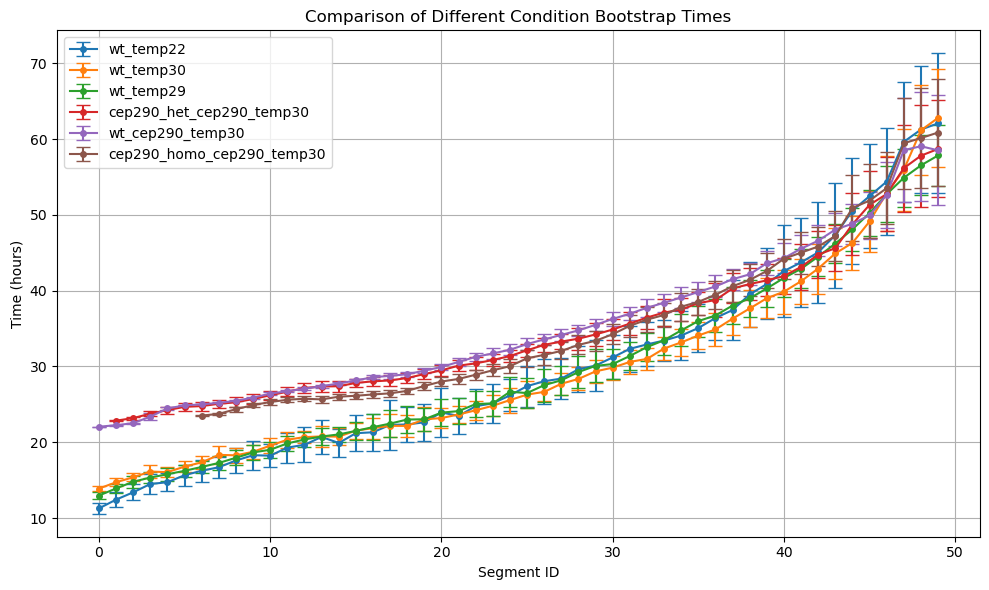

In [41]:
# Number of bootstrap journeys to run
num_journeys = 100  # Adjust based on computational resources

# Initialize lists to hold data and labels for the plot
data_list = []  # List of (summary_df, df_augmented) tuples
labels = []  # List of condition labels (phenotypes)



# Loop through each perturbation in pert_comparison
for pert in df_augmented_projec_wt["phenotype"].unique():
    # Filter the augmented dataframe for the current phenotype
    print(pert)
    df_augmented_temp = df_augmented_projec_wt[df_augmented_projec_wt["phenotype"] == pert]

    # Run bootstrap journeys for the current phenotype
    journeys_df_temp = run_bootstrap_journeys(
        df_augmented=df_augmented_temp,  # Subset to perturbation you want to calculate spline for
        num_journeys=num_journeys,
        start_segment=0,
        end_segment=None,  # Defaults to max segment
        random_seed=42,
        time_column="experiment_time",
        segment_id_col="ref_seg_id"
    )

    # Compute the summary statistics (mean_time, std_time, etc.) for bootstrap journeys
    summary_df_temp =  summarize_journeys(journeys_df_temp)

    # Add summary_df and filtered augmented dataframe to the data list
    data_list.append((summary_df_temp, df_augmented_temp))

    # Add the current phenotype as a label
    labels.append(pert)


# Plot the comparison of bootstrap times across different conditions
plot_multi_bootstrap(
    data_list=data_list,
    labels=labels,
    title="Comparison of Different Condition Bootstrap Times",
    use_time_init=True  # Set to False if you don't want an offset
)


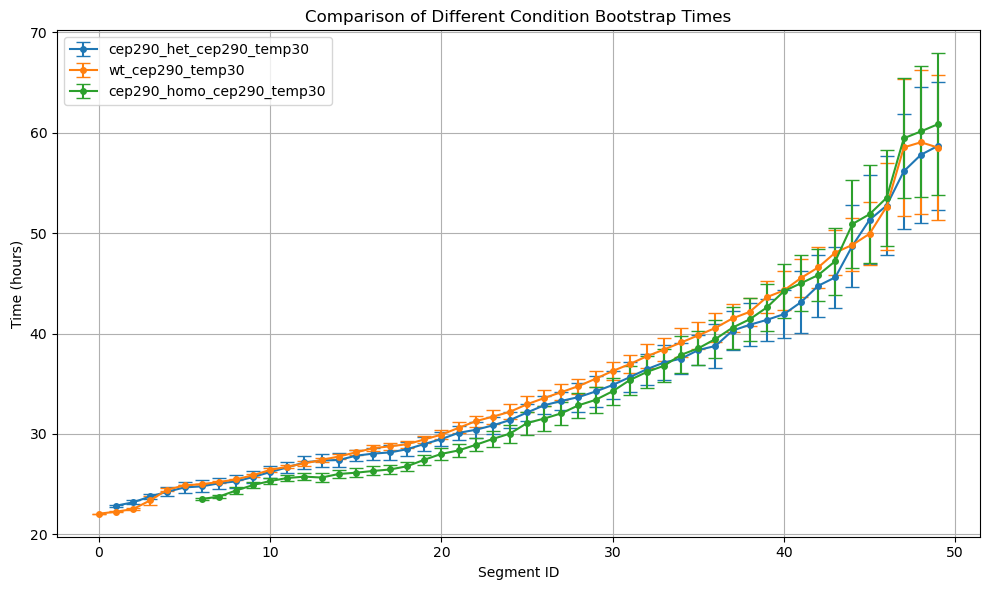

In [42]:
plot_multi_bootstrap(
    data_list=data_list[3::],
    labels=labels[3::],
    title="Comparison of Different Condition Bootstrap Times",
    use_time_init=True  # Set to False if you don't want an offset
)

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/spline_morph_spline_metrics.py:1513: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/spline_morph_spline_metrics.py:1513: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



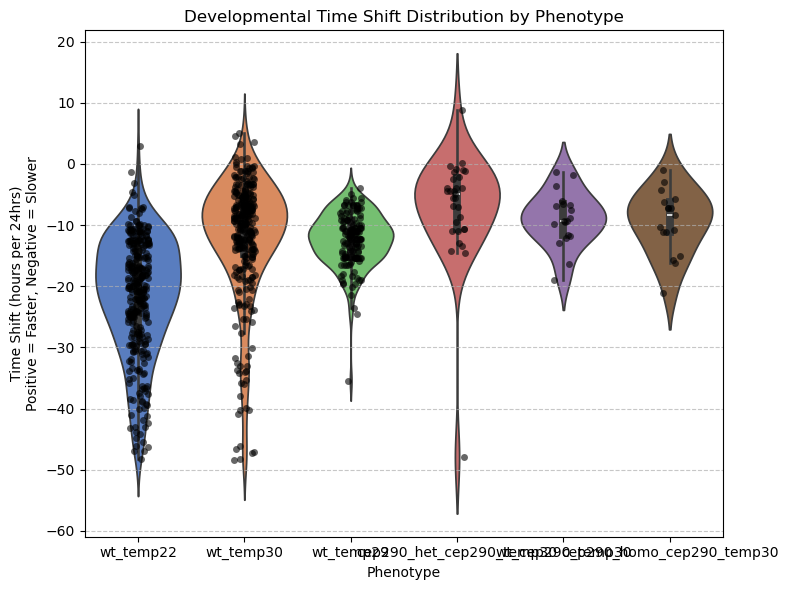

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/spline_morph_spline_metrics.py:1513: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/spline_morph_spline_metrics.py:1513: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



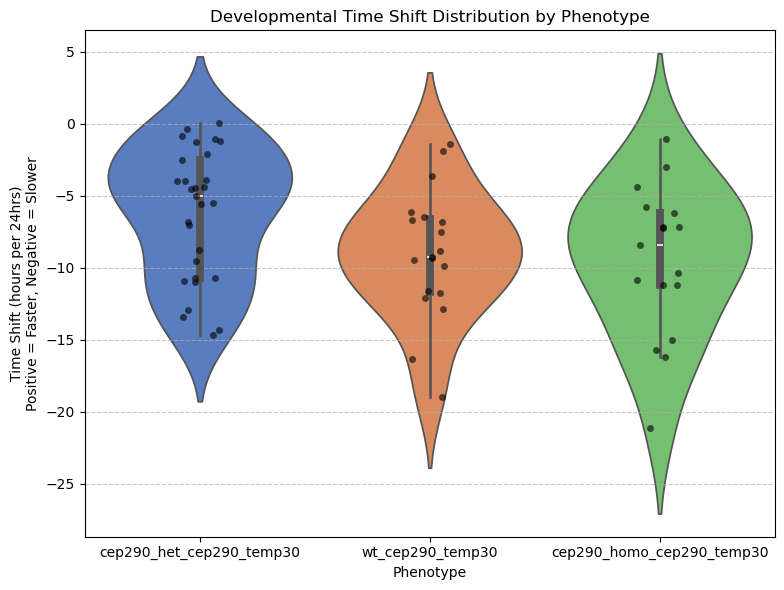

In [45]:
wt_30_spline = data_list[3][0]
wt_30_spline["mean_time_hours"] = (wt_30_spline["mean_time"] / (3600))


shift_df = compute_developmental_shifts(
    df_embryos         = df_augmented_projec_wt,
    summary_df_wt_calc = wt_30_spline,
    color_by           = "phenotype"   )


plot_developmental_shifts_violin(shift_df, color_by="phenotype")

plot_developmental_shifts_violin(shift_df[shift_df["phenotype"].isin(phenotypes_of_interest)], color_by="phenotype")

In [57]:
def plot_hypotenuse_over_stage(
    df,
    phenotypes_to_include=None,
    window_size=5,
    figsize=(12, 8),
    palette="tab10",
    alpha=0.5,
    plot_individual_embryos=True,
    plot_average=True,
    highlight_embryos=None,
    max_hpf=None,
    min_points_per_embryo=5,
    save_path=None,
    show_legend=True,
    title=None
):
    """
    Plot hypotenuse (distance from spline) over predicted stage with smoothing.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data, must have columns:
        ['hypotenuse', 'embryo_id', 'phenotype', 'predicted_stage_hpf']
    phenotypes_to_include : list, optional
        List of phenotypes to include in the plot. If None, all phenotypes are included.
    window_size : int, default=5
        Window size for rolling average smoothing.
    figsize : tuple, default=(12, 8)
        Figure size (width, height) in inches.
    palette : str or dict, default="tab10"
        Color palette name or dict mapping phenotypes to colors.
    alpha : float, default=0.5
        Transparency level for individual embryo lines.
    plot_individual_embryos : bool, default=True
        Whether to plot individual embryo traces.
    plot_average : bool, default=True
        Whether to plot average line per phenotype.
    highlight_embryos : list, optional
        List of embryo_ids to highlight with thicker lines.
    max_hpf : float, optional
        Maximum hours post-fertilization to include in the plot.
    min_points_per_embryo : int, default=5
        Minimum number of data points required for an embryo to be included.
    save_path : str, optional
        Path to save the figure, if provided.
    show_legend : bool, default=True
        Whether to show the legend.
    title : str, optional
        Plot title. If None, a default title is used.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure required columns exist
    required_cols = ['hypotenuse', 'embryo_id', 'phenotype', 'predicted_stage_hpf']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Filter by phenotype if specified
    if phenotypes_to_include is not None:
        df = df[df['phenotype'].isin(phenotypes_to_include)]
    
    # Filter by max_hpf if specified
    if max_hpf is not None:
        df = df[df['predicted_stage_hpf'] <= max_hpf]
    
    # Filter embryos with too few data points
    embryo_counts = df.groupby('embryo_id').size()
    valid_embryos = embryo_counts[embryo_counts >= min_points_per_embryo].index
    df = df[df['embryo_id'].isin(valid_embryos)]
    
    # If DataFrame is empty after filtering, return empty plot
    if df.empty:
        plt.figure(figsize=figsize)
        plt.text(0.5, 0.5, "No data available after filtering", 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=14)
        plt.gca().set_axis_off()
        return plt.gcf()
    
    # Setup figure
    plt.figure(figsize=figsize)
    
    # Get unique phenotypes and assign colors
    unique_phenotypes = df['phenotype'].unique()
    if isinstance(palette, str):
        color_palette = sns.color_palette(palette, n_colors=len(unique_phenotypes))
        phenotype_colors = {phenotype: color_palette[i] for i, phenotype in enumerate(unique_phenotypes)}
    else:
        # If palette is a dict, use it directly
        phenotype_colors = palette
    
    # Store lines for legend
    phenotype_lines = {}
    highlight_lines = {}
    
    # Plot individual embryos
    if plot_individual_embryos:
        for embryo_id, group in df.groupby('embryo_id'):
            phenotype = group['phenotype'].iloc[0]
            color = phenotype_colors.get(phenotype, 'gray')
            
            # Sort by predicted_stage_hpf
            group = group.sort_values('predicted_stage_hpf')
            
            # Apply smoothing with rolling window
            group['smooth_hypotenuse'] = group['hypotenuse'].rolling(
                window=window_size, min_periods=1, center=True
            ).mean()
            
            # Determine line properties
            is_highlight = highlight_embryos is not None and embryo_id in highlight_embryos
            line_alpha = 1.0 if is_highlight else alpha
            line_width = 2.5 if is_highlight else 1
            
            # Plot the line
            line = plt.plot(
                group['predicted_stage_hpf'], 
                group['smooth_hypotenuse'], 
                color=color, 
                alpha=line_alpha,
                linewidth=line_width,
                label=None  # We'll add to legend separately
            )
            
            # Store for legend if this is a highlight
            if is_highlight:
                highlight_lines[embryo_id] = line[0]
    
    # Plot average line per phenotype
    if plot_average:
        for phenotype, group in df.groupby('phenotype'):
            color = phenotype_colors.get(phenotype, 'gray')
            
            # Group by predicted_stage_hpf bins (0.5 hour increments)
            group['stage_bin'] = (group['predicted_stage_hpf'] * 2).astype(int) / 2
            
            # Calculate mean per bin
            stage_means = group.groupby('stage_bin')['hypotenuse'].mean().reset_index()
            
            # Sort by stage
            stage_means = stage_means.sort_values('stage_bin')
            
            # Apply smoothing
            stage_means['smooth_hypotenuse'] = stage_means['hypotenuse'].rolling(
                window=window_size, min_periods=1, center=True
            ).mean()
            
            # Plot average line
            line = plt.plot(
                stage_means['stage_bin'], 
                stage_means['smooth_hypotenuse'], 
                color=color, 
                linewidth=5,
                label=f"{phenotype} (n={len(group['embryo_id'].unique())})"
            )
            
            # Store for legend
            phenotype_lines[phenotype] = line[0]
    
    # Set title and labels
    title = title or "Distance from Spline by Developmental Stage"
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Stage (hpf)', fontsize=12)
    plt.ylabel('Distance from Spline (Hypotenuse)', fontsize=12)
    
    # Add legend
    if show_legend:
        # Add phenotype legend
        if plot_average and phenotype_lines:
            plt.legend(
                handles=list(phenotype_lines.values()),
                labels=[f"{phenotype} (n={len(df[df['phenotype']==phenotype]['embryo_id'].unique())})" 
                        for phenotype in phenotype_lines.keys()],
                title="Phenotype",
                loc="upper left"
            )
        
        # Add highlight legend
        if highlight_embryos and highlight_lines:
            if plot_average:  # Add a separate legend for highlights if we already have one for phenotypes
                plt.legend(
                    handles=list(highlight_lines.values()),
                    labels=list(highlight_lines.keys()),
                    title="Highlighted Embryos",
                    loc="upper right"
                )
            else:  # Otherwise combine them
                all_lines = {**phenotype_lines, **highlight_lines}
                all_labels = list(phenotype_lines.keys()) + list(highlight_lines.keys())
                plt.legend(
                    handles=list(all_lines.values()),
                    labels=all_labels,
                    loc="best"
                )
    
    # Set grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()


def plot_hypotenuse_heatmap(
    df,
    phenotypes_to_include=None,
    figsize=(14, 8),
    max_hpf=None,
    bin_width=0.5,
    cmap="viridis",
    save_path=None,
    title=None
):
    """
    Create a heatmap of hypotenuse values across developmental stages for different phenotypes.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data, must have columns:
        ['hypotenuse', 'embryo_id', 'phenotype', 'predicted_stage_hpf']
    phenotypes_to_include : list, optional
        List of phenotypes to include in the plot. If None, all phenotypes are included.
    figsize : tuple, default=(14, 8)
        Figure size (width, height) in inches.
    max_hpf : float, optional
        Maximum hours post-fertilization to include in the plot.
    bin_width : float, default=0.5
        Width of stage bins in hours.
    cmap : str, default="viridis"
        Colormap to use for the heatmap.
    save_path : str, optional
        Path to save the figure, if provided.
    title : str, optional
        Plot title. If None, a default title is used.
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    # Make a copy to avoid modifying the original
    df = df.copy()
    
    # Ensure required columns exist
    required_cols = ['hypotenuse', 'embryo_id', 'phenotype', 'predicted_stage_hpf']
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")
    
    # Filter by phenotype if specified
    if phenotypes_to_include is not None:
        df = df[df['phenotype'].isin(phenotypes_to_include)]
    
    # Filter by max_hpf if specified
    if max_hpf is not None:
        df = df[df['predicted_stage_hpf'] <= max_hpf]
    
    # If DataFrame is empty after filtering, return empty plot
    if df.empty:
        plt.figure(figsize=figsize)
        plt.text(0.5, 0.5, "No data available after filtering", 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=14)
        plt.gca().set_axis_off()
        return plt.gcf()
    
    # Bin the stages
    df['stage_bin'] = (df['predicted_stage_hpf'] / bin_width).astype(int) * bin_width
    
    # Calculate mean hypotenuse per phenotype and stage bin
    pivot_data = df.pivot_table(
        values='hypotenuse',
        index='phenotype',
        columns='stage_bin',
        aggfunc='mean'
    )
    
    # Create the figure
    plt.figure(figsize=figsize)
    
    # Create heatmap
    ax = sns.heatmap(
        pivot_data,
        cmap=cmap,
        robust=True,
        cbar_kws={'label': 'Average Distance from Spline'},
        annot=False
    )
    
    # Format x-axis as HPF - using column values directly
    x_ticks = pivot_data.columns.tolist()
    x_labels = [f"{x:.1f}" for x in x_ticks]
    ax.set_xticklabels(x_labels)
    
    # Set title and labels
    title = title or "Distance from Spline Heatmap by Phenotype and Stage"
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted Stage (hpf)', fontsize=12)
    plt.ylabel('Phenotype', fontsize=12)
    
    # Add count to y-axis labels
    phenotype_counts = df.groupby('phenotype')['embryo_id'].nunique()
    y_labels = [f"{y.get_text()} (n={phenotype_counts.get(y.get_text(), 0)})" 
                for y in ax.get_yticklabels()]
    ax.set_yticklabels(y_labels)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()


# # Example usage:
# target_phenotypes = ['cep290_het_cep290_temp30', 'wt_cep290_temp30', 'cep290_homo_cep290_temp30']

# # Line plot with individual embryos and averages
# plot_hypotenuse_over_stage(
#     df=df_augmented_projec_wt,
#     phenotypes_to_include=target_phenotypes,
#     window_size=5,
#     max_hpf=60,
#     save_path=os.path.join(plot_dir,"hypotenuse_stage_plot_v2.pdf")
# )

# # Heatmap view
# plot_hypotenuse_heatmap(
#     df=df_augmented_projec_wt,
#     phenotypes_to_include=target_phenotypes,
#     max_hpf=60,
#     bin_width=1.0,
#     save_path=os.path.join(plot_dir,"hypotenuse_heatmap_v2.pdf")
# )

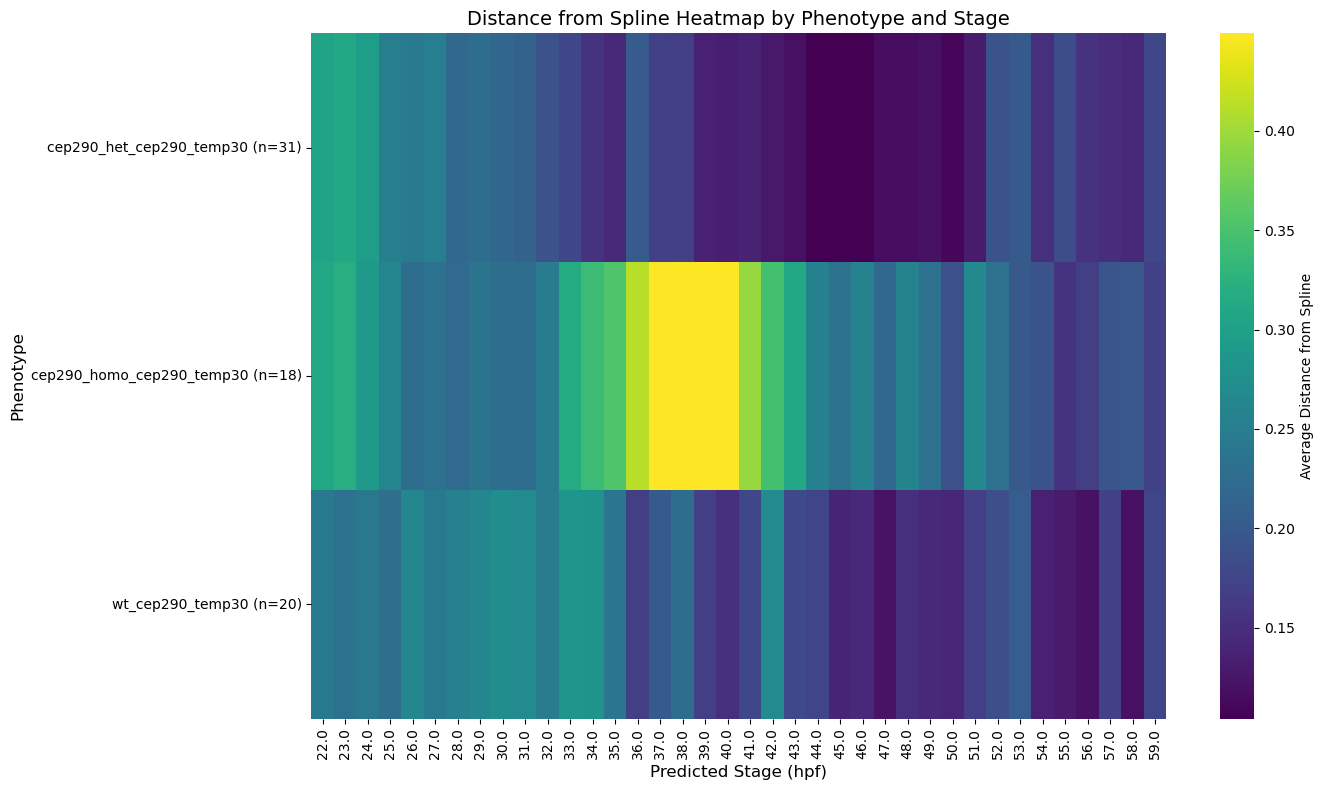

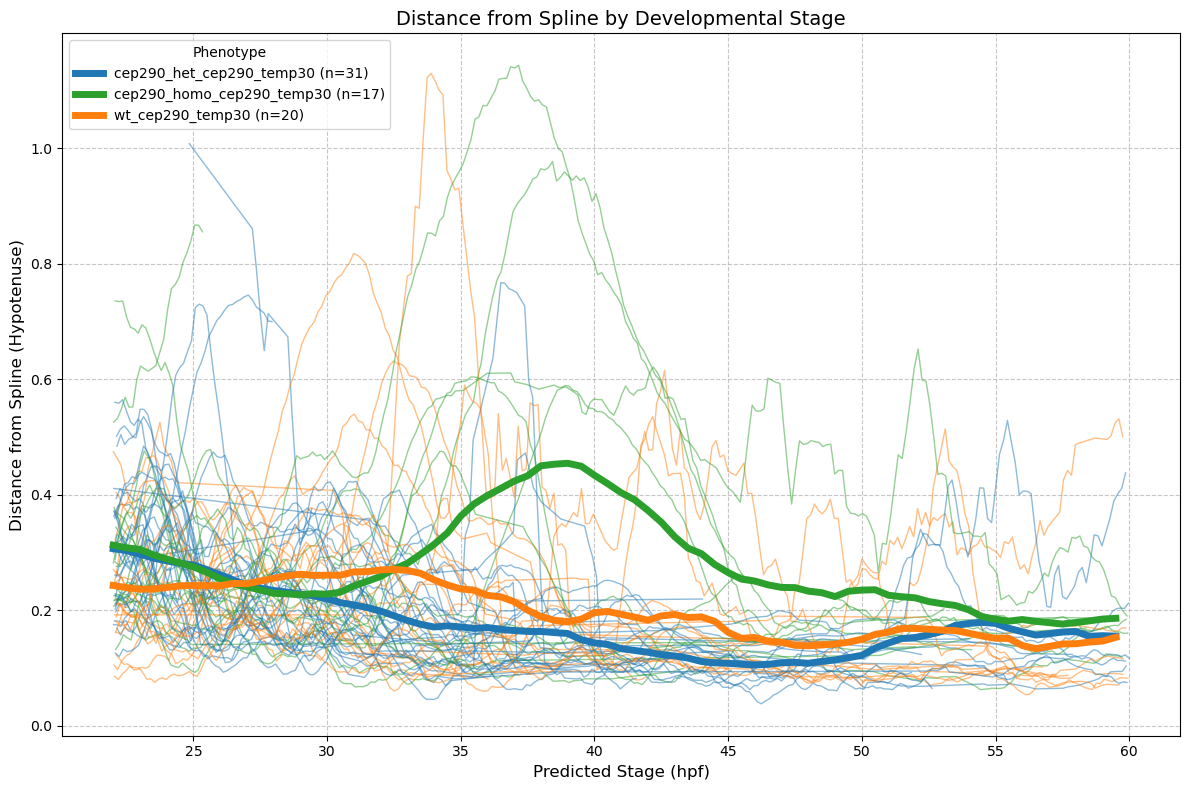

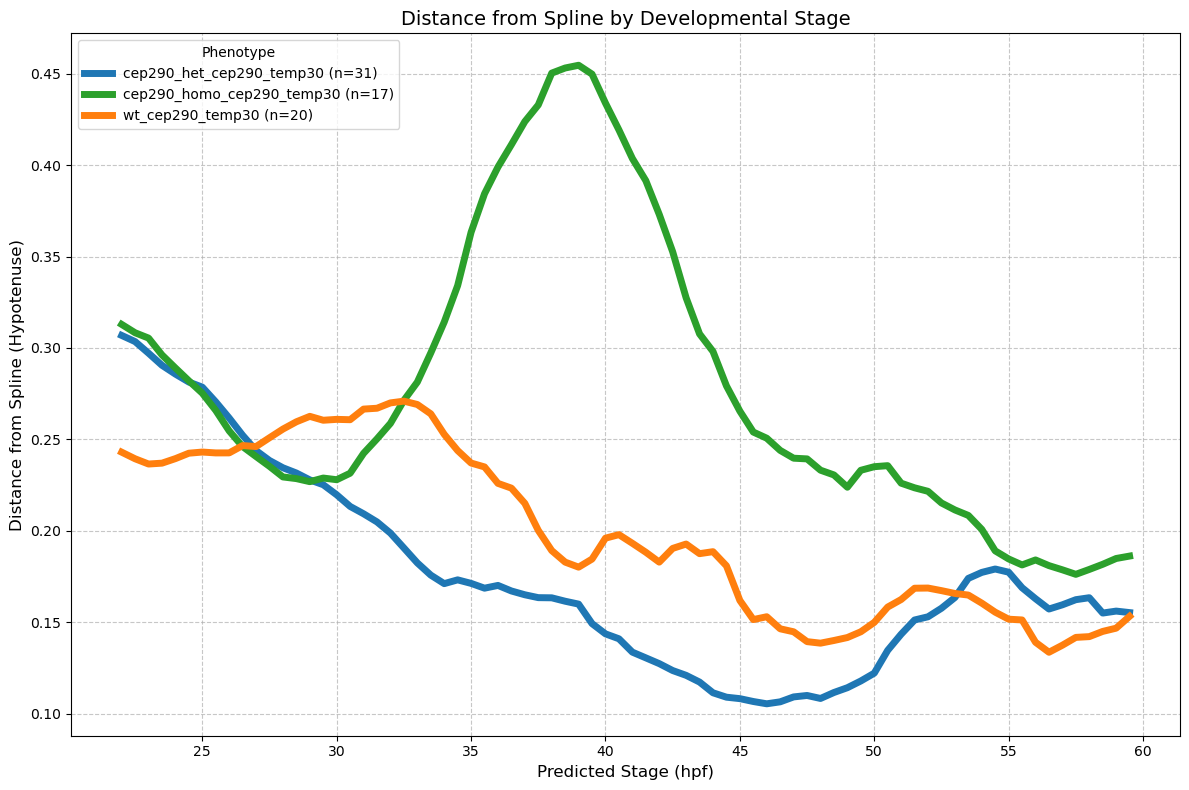

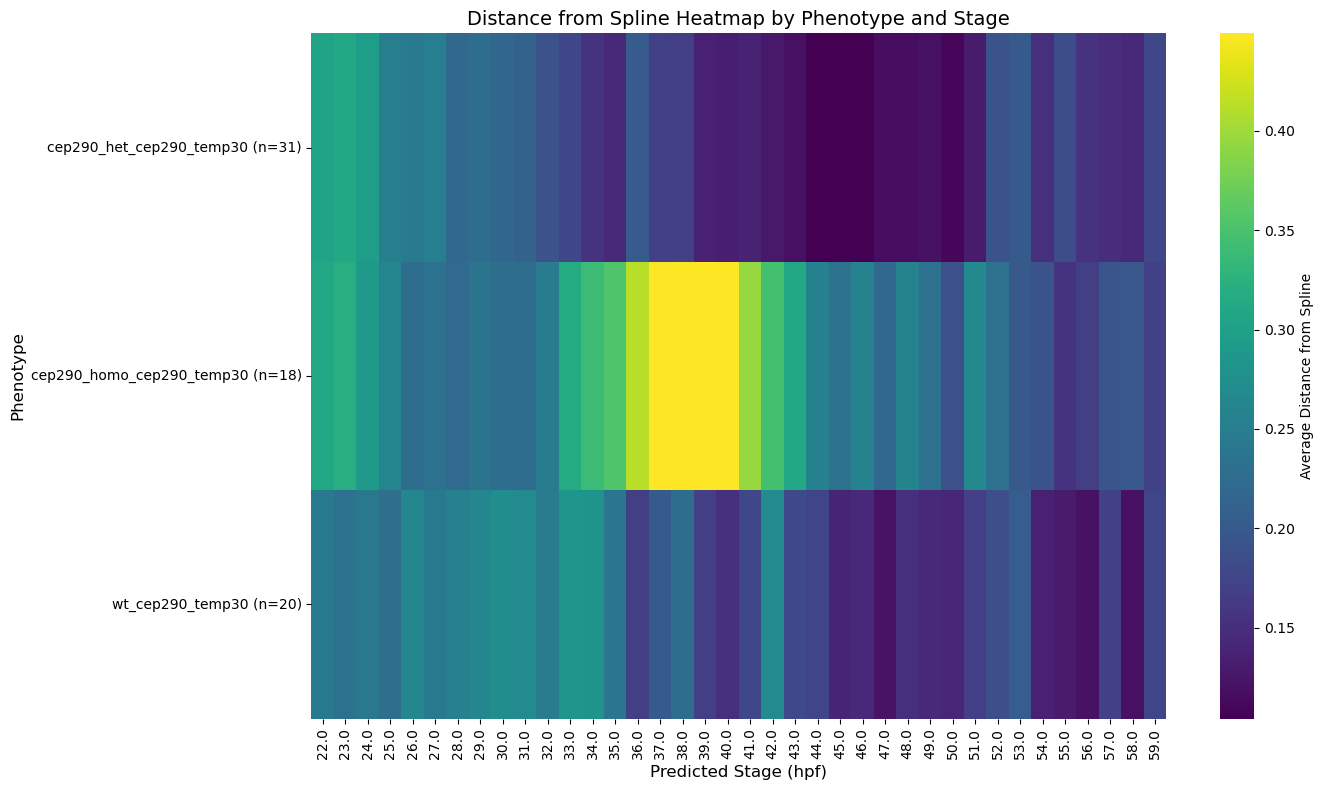

In [59]:
# Line plot with individual embryos and averages

target_phenotypes = [ 'cep290_het_cep290_temp30','wt_cep290_temp30' ,'cep290_homo_cep290_temp30']


plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    phenotypes_to_include=target_phenotypes,
    window_size=10,
    max_hpf=60,
    save_path=os.path.join(plot_dir,"hypotenuse_stage_plot.pdf")
)

plot_hypotenuse_over_stage(
    df=df_augmented_projec_wt,
    phenotypes_to_include=target_phenotypes,
    window_size=10,
    max_hpf=60,
    plot_individual_embryos=False,
    save_path=os.path.join(plot_dir,"hypotenuse_stage_plot_no_indv_embryos.pdf")
)


# Heatmap view
plot_hypotenuse_heatmap(
    df=df_augmented_projec_wt,
    phenotypes_to_include=target_phenotypes,
    max_hpf=60,
    bin_width=1.0,
    save_path=os.path.join(plot_dir,"hypotenuse_heatmap_v2.pdf")
)
